# Structure MCMC

## Theory

## Algorithm

Pseudocode for implementing the Metropolis-Hastings algorithm for structure learning in graphs:

```python
Initialize a graph G
For a set number of iterations do:
    Propose a new graph G' by making a small random change to G
    Calculate the acceptance probability A(G, G') as follows:
       Compute the posterior probabilities P(G | D) and P(G' | D)
       if the proposal distribution is symmetric:
          A(G, G') = min(1, P(G' | D) / P(G | D))
       else:
           Compute the proposal probabilities Q(G | G') and Q(G' | G)
           A(G, G') = min(1, [P(G' | D) * Q(G | G')] / [P(G | D) * Q(G' | G)])
    Generate a random number u from a uniform distribution between 0 and 1
       if u < A(G, G'), accept the proposed graph: G = G'
return the final graph G
```



## Implementation

In [ ]:
import pandas as pd
import numpy as np
import networkx as nx

import random

In [ ]:

# create a fully connected graph
# todo: add PC algo here
def compute_initial_graph( data : pd.DataFrame ):
    # initialize the graph
    graph = nx.DiGraph()
    
    # add all nodes
    graph.add_nodes_from(data.columns)
    
    # add all edges
    graph.add_edges_from( list( data.columns ) )
    return graph

# todo: check after adding, reversing or deleting an edge, if the graph is still a DAG
def propose_new_graph(G : nx.DiGraph):
    G_prime = G.copy()

    # Get a list of the graphs edges and non-edges
    edges = list(G_prime.edges)
    non_edges = list(nx.non_edges(G_prime))

    # List of possible operations
    operations = []
    if non_edges:
        operations.append("add_edge")
    if edges:
        operations.append("delete_edge")
        operations.append("reverse_edge")

    # Choose a single random operation
    operation = random.choice(operations)

    if operation == "add_edge":
        i, j = random.choice(non_edges)
        G_prime.add_edge(i, j)
        return G_prime
    
    if operation == "delete_edge":
        i, j = random.choice(edges)
        G_prime.remove_edge(i, j)
        return G_prime
    
    # reverse_edge
    i, j = random.choice(edges)
    G_prime.remove_edge(i, j)
    G_prime.add_edge(j, i)

    return G_prime



def compute_posterior( graph : nx.DiGraph, data : pd.DataFrame ):
    
    pass

def compute_symmetry( graph : nx.DiGraph, graph_prime : nx.DiGraph ):
    
    pass

def compute_non_symmetric_acceptance_ratio(G, G_prime, data):
    
    pass

    
def structured_MCMC(data : pd.DataFrame, iterations : int, is_proposal_symmetric : bool = True):
    
    graph_candidates = []
    posterior_candidates = []
    
    # Initialize the graph
    G_current = compute_initial_graph( data )
    graph_candidates.append(G_current)
    
    posterior_current = compute_posterior(G_current, data)
    posterior_candidates.append(posterior_current)

    for _ in range(iterations):
        # Propose a new graph
        G_proposed = propose_new_graph(G_current)

        # Calculate the acceptance probability
        posterior_G_current = compute_posterior(G_current, data)
        posterior_G_proposed = compute_posterior(G_proposed, data)

        if is_proposal_symmetric:
            # A(G, G') = min(1, P(G' | D) / P(G | D))
            A = min(1, posterior_G_proposed / posterior_G_current)
        else:
            #  A(G, G') = min(1, [P(G' | D) * Q(G | G')] / [P(G | D) * Q(G' | G)])
            # todo: this function is not implemented yet
            A =  compute_non_symmetric_acceptance_ratio(G_current, G_proposed, data)
            pass

        # Generate a random number
        u = np.random.uniform(0, 1)

        # Accept or reject the proposed graph
        if u < A: 
            G_current = G_proposed
            posterior_G_current = posterior_G_proposed
            
        # keep track of candiates
        posterior_candidates.append(posterior_current)
        graph_candidates.append(G_current)


    return posterior_candidates, graph_candidates

## Execution

### The Model


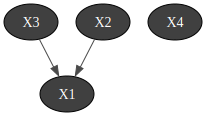

In [2]:
import pyAgrum as gum
import pyAgrum.lib.notebook as gnb

cbn = gum.fastBN("X1<-X2;X4;X1<-X3")
gnb.showBN(cbn)

### The Dataset

In [3]:
import pandas as pd

data = pd.read_csv( "data/bn_data.csv" , sep='\t')
data

,X1,X2,X3,X4
0,0.56,0.48,0.60,0.05
1,0.46,0.40,0.45,0.26
2,0.58,0.62,0.69,0.76
3,0.45,0.57,0.52,0.44
4,0.35,0.69,0.46,0.69
...,...,...,...,...
994,0.64,0.22,0.57,0.54
995,0.37,0.62,0.46,0.93
996,0.52,0.46,0.53,0.16
997,0.36,0.57,0.42,0.51


### Structure MCMC

In [ ]:
NUM_ITERATIONS = 1000

G, candidates = structured_MCMC(data, NUM_ITERATIONS)



## Convergence Analysis

In [ ]:
import matplotlib.pyplot as plt

def plot_trace(graphs):
    # Compute the number of edges in each graph
    num_edges = [G.number_of_edges() for G in graphs]

    # Create a figure and an axis
    fig, ax = plt.subplots()

    # Plot the number of edges
    ax.plot(num_edges)

    # Set the title and labels
    ax.set_title("Trace plot of the number of edges")
    ax.set_xlabel("Step")
    ax.set_ylabel("Number of edges")

    # Show the plot
    plt.show()
